In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Dataset Information:
Shape: (10000, 14)

First few rows:
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        11393

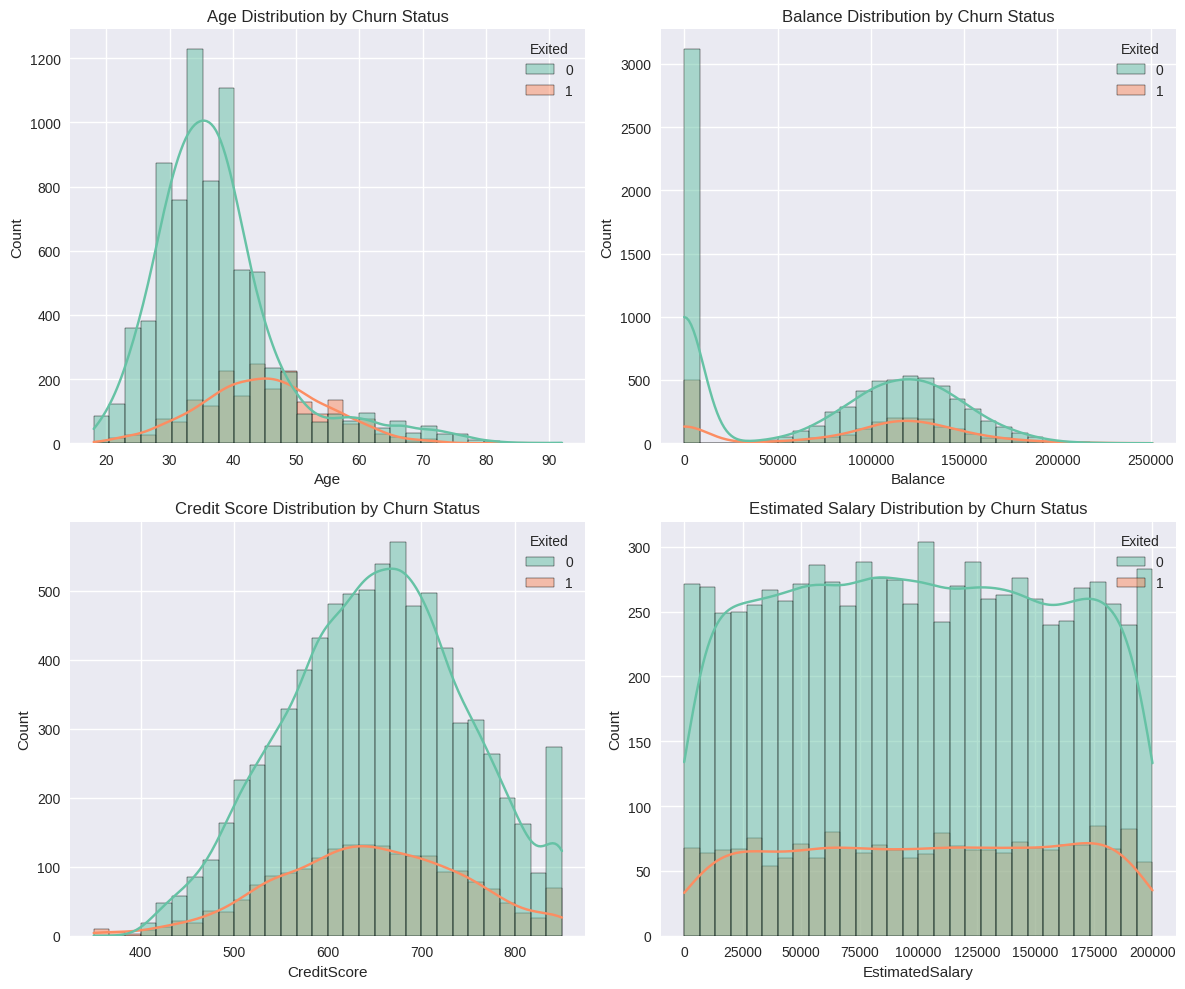

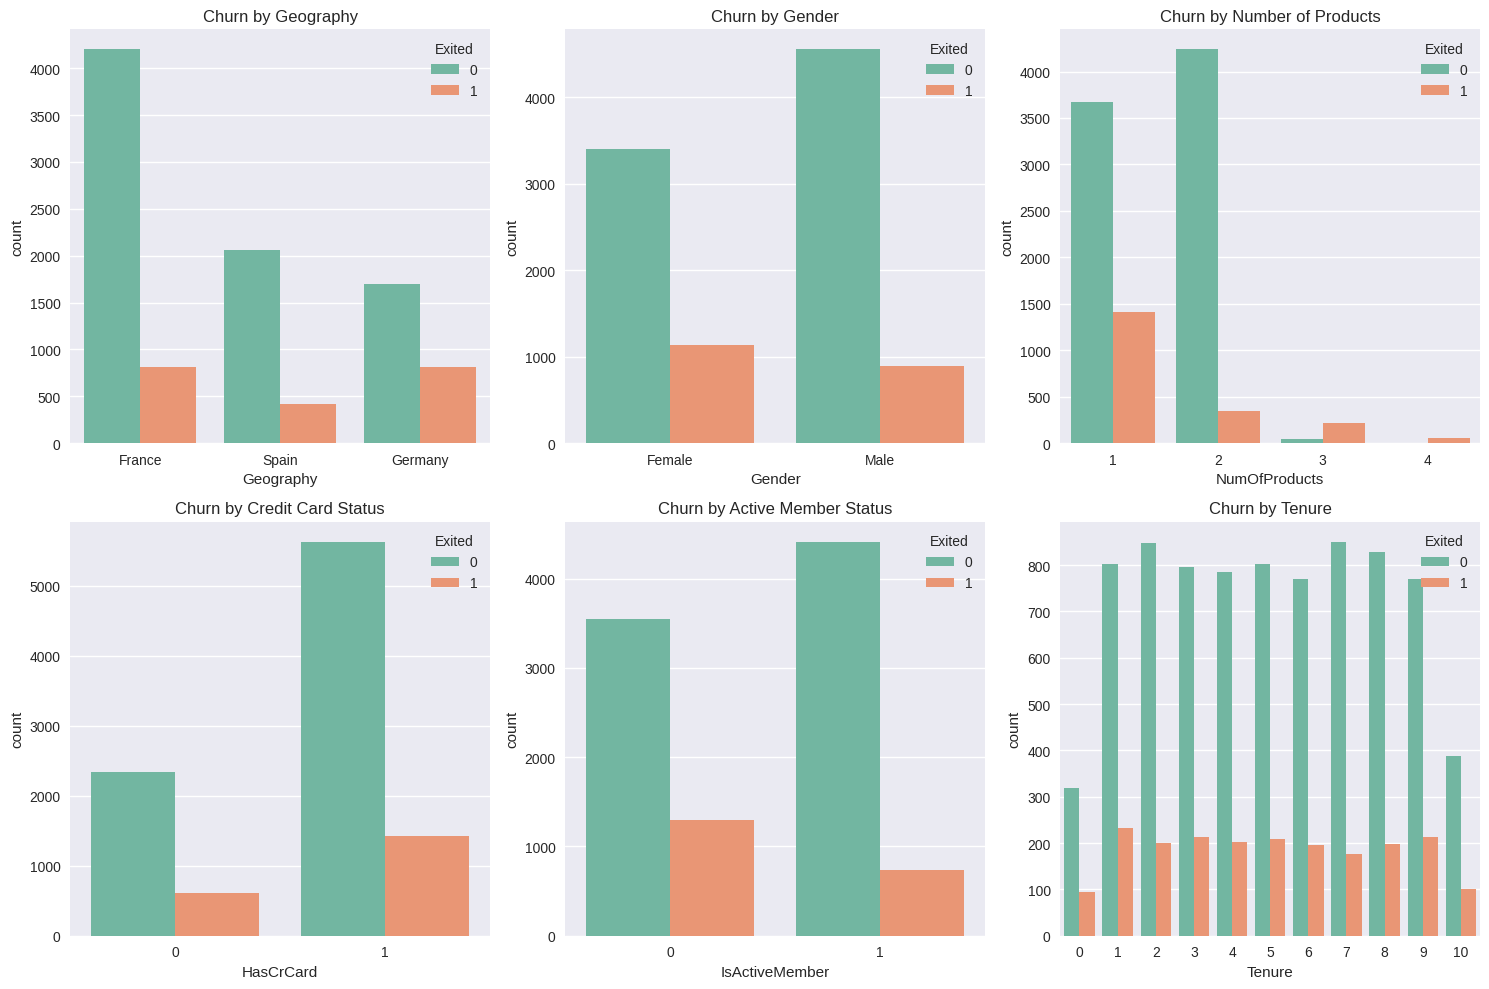

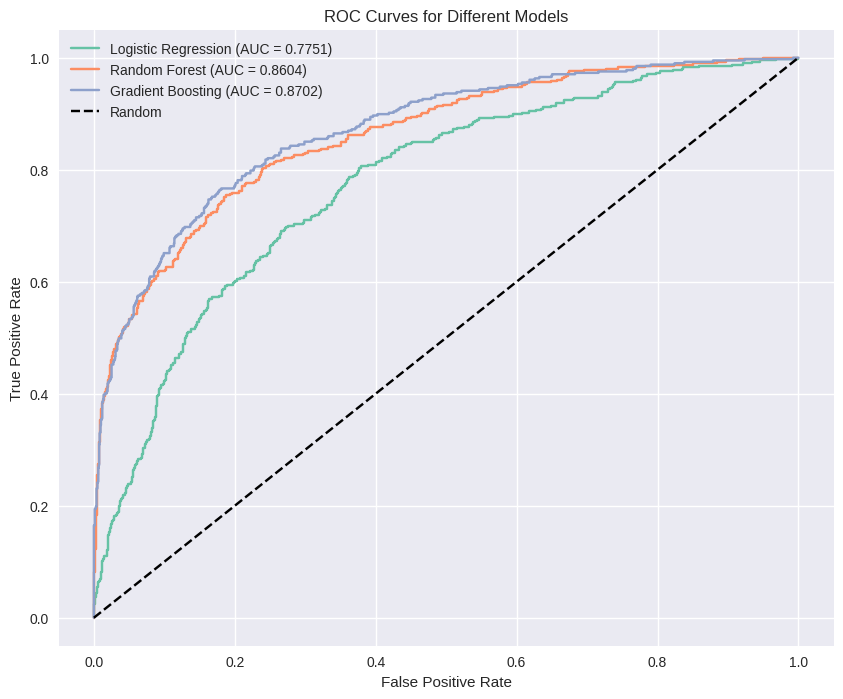

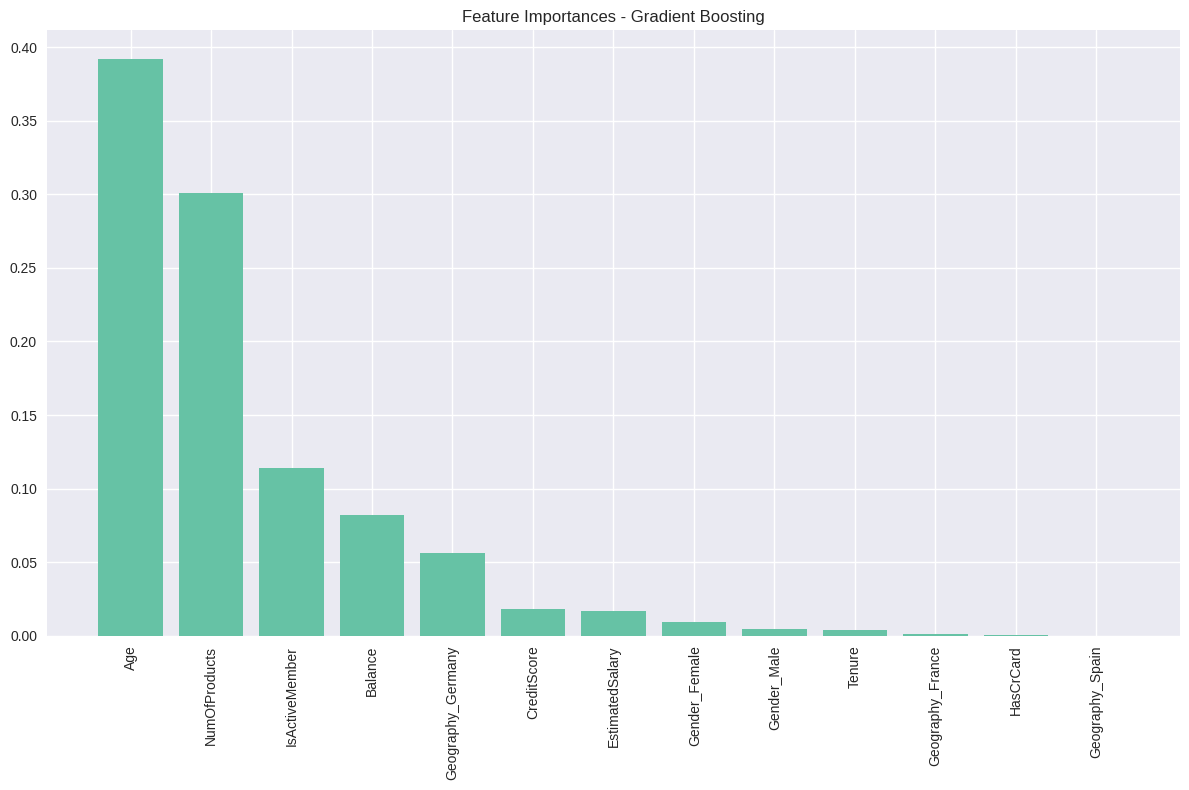

<Figure size 1200x800 with 0 Axes>

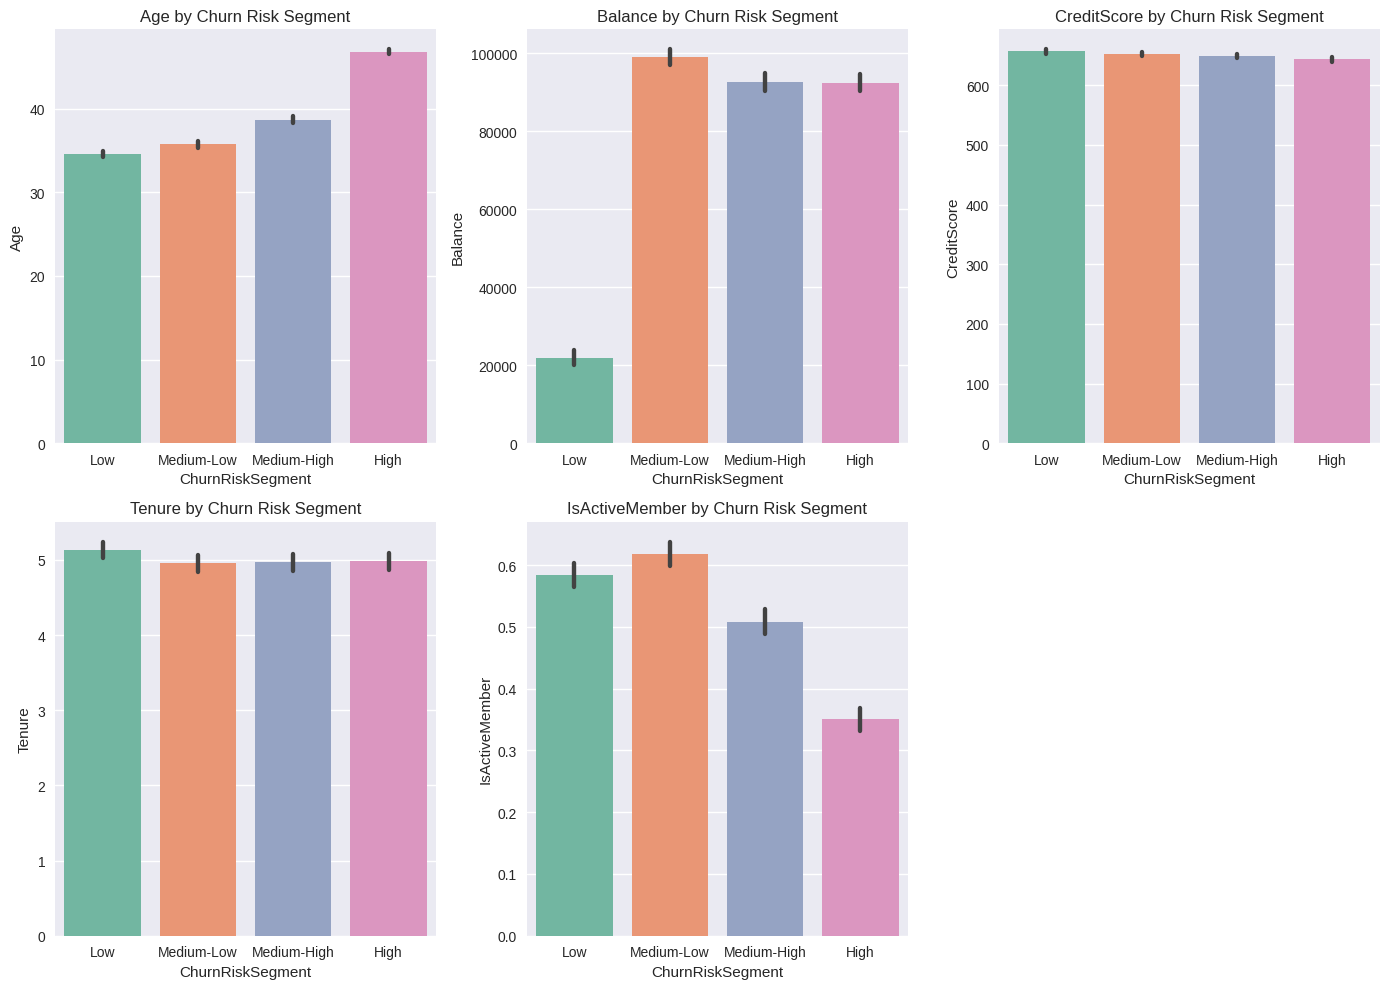

In [1]:
# Bank Customer Churn Prediction
# This code builds a machine learning model to predict customer churn in a bank

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")

# Load the dataset
df = pd.read_csv('/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv')

# Display basic information about the dataset
print("Dataset Information:")
print(f"Shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Exploratory Data Analysis (EDA)
print("\nBasic statistics:")
print(df.describe())

# Check the distribution of target variable
print("\nTarget variable distribution:")
print(df['Exited'].value_counts(normalize=True))

# Prepare for visualizations
plt.figure(figsize=(12, 10))

# Analyze age distribution by churn status
plt.subplot(2, 2, 1)
sns.histplot(data=df, x='Age', hue='Exited', kde=True, bins=30)
plt.title('Age Distribution by Churn Status')

# Analyze balance distribution by churn status
plt.subplot(2, 2, 2)
sns.histplot(data=df, x='Balance', hue='Exited', kde=True, bins=30)
plt.title('Balance Distribution by Churn Status')

# Analyze credit score distribution by churn status
plt.subplot(2, 2, 3)
sns.histplot(data=df, x='CreditScore', hue='Exited', kde=True, bins=30)
plt.title('Credit Score Distribution by Churn Status')

# Analyze estimated salary distribution by churn status
plt.subplot(2, 2, 4)
sns.histplot(data=df, x='EstimatedSalary', hue='Exited', kde=True, bins=30)
plt.title('Estimated Salary Distribution by Churn Status')

plt.tight_layout()
plt.savefig('numeric_distributions.png')

# Categorical variables analysis
plt.figure(figsize=(15, 10))

# Geography and churn
plt.subplot(2, 3, 1)
sns.countplot(data=df, x='Geography', hue='Exited')
plt.title('Churn by Geography')

# Gender and churn
plt.subplot(2, 3, 2)
sns.countplot(data=df, x='Gender', hue='Exited')
plt.title('Churn by Gender')

# Number of products and churn
plt.subplot(2, 3, 3)
sns.countplot(data=df, x='NumOfProducts', hue='Exited')
plt.title('Churn by Number of Products')

# Has credit card and churn
plt.subplot(2, 3, 4)
sns.countplot(data=df, x='HasCrCard', hue='Exited')
plt.title('Churn by Credit Card Status')

# Active member and churn
plt.subplot(2, 3, 5)
sns.countplot(data=df, x='IsActiveMember', hue='Exited')
plt.title('Churn by Active Member Status')

# Tenure and churn
plt.subplot(2, 3, 6)
sns.countplot(data=df, x='Tenure', hue='Exited')
plt.title('Churn by Tenure')

plt.tight_layout()
plt.savefig('categorical_distributions.png')

# Feature Engineering
# Drop unnecessary columns
df_model = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

# Prepare data for modeling
X = df_model.drop('Exited', axis=1)
y = df_model['Exited']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Create preprocessing pipelines for both numerical and categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Build model pipelines
models = {
    'Logistic Regression': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ]),
    'Random Forest': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    'Gradient Boosting': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(random_state=42))
    ])
}

# Parameter grids for grid search
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l2'],
        'classifier__solver': ['liblinear']
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5, 10]
    },
    'Gradient Boosting': {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7]
    }
}

# Train and evaluate models
best_models = {}
model_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Perform grid search
    grid_search = GridSearchCV(
        model, 
        param_grids[name], 
        cv=5, 
        scoring='roc_auc', 
        n_jobs=-1, 
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    # Store best model
    best_models[name] = grid_search.best_estimator_
    
    # Evaluate on test data
    y_pred = grid_search.predict(X_test)
    y_prob = grid_search.predict_proba(X_test)[:, 1]
    
    # Store results
    model_results[name] = {
        'Best Parameters': grid_search.best_params_,
        'ROC AUC Score': roc_auc_score(y_test, y_prob),
        'Classification Report': classification_report(y_test, y_pred),
        'Confusion Matrix': confusion_matrix(y_test, y_pred),
        'Y Proba': y_prob
    }
    
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"ROC AUC Score for {name}: {roc_auc_score(y_test, y_prob):.4f}")
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))

# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

for name, results in model_results.items():
    fpr, tpr, _ = roc_curve(y_test, results['Y Proba'])
    auc = results['ROC AUC Score']
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend()
plt.savefig('roc_curves.png')

# Identify the best model based on ROC AUC score
best_model_name = max(model_results, key=lambda x: model_results[x]['ROC AUC Score'])
best_model = best_models[best_model_name]
print(f"\nThe best performing model is {best_model_name} with ROC AUC: {model_results[best_model_name]['ROC AUC Score']:.4f}")

# Feature importance analysis for the best model
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    # For tree-based models, extract feature importance
    feature_names = (
        numerical_features +
        list(best_model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features))
    )
    
    importances = best_model.named_steps['classifier'].feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 8))
    plt.title(f'Feature Importances - {best_model_name}')
    plt.bar(range(len(indices)), importances[indices], align='center')
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    
    print("\nTop 10 most important features:")
    for i in range(min(10, len(feature_names))):
        print(f"{feature_names[indices[i]]}: {importances[indices[i]]:.4f}")
elif best_model_name == 'Logistic Regression':
    # For logistic regression, extract coefficients
    feature_names = (
        numerical_features +
        list(best_model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features))
    )
    
    coefficients = best_model.named_steps['classifier'].coef_[0]
    importance = np.abs(coefficients)
    indices = np.argsort(importance)[::-1]
    
    plt.figure(figsize=(12, 8))
    plt.title(f'Feature Coefficients - {best_model_name}')
    plt.bar(range(len(indices)), coefficients[indices], align='center')
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.savefig('feature_coefficients.png')
    
    print("\nTop 10 most important features:")
    for i in range(min(10, len(feature_names))):
        print(f"{feature_names[indices[i]]}: {coefficients[indices[i]]:.4f}")

# Save the best model
import joblib
joblib.dump(best_model, 'churn_prediction_model.pkl')
print("\nBest model saved as 'churn_prediction_model.pkl'")

# Customer segmentation based on churn risk
def predict_churn_probability(model, data):
    return model.predict_proba(data)[:, 1]

# Predict churn probabilities for all customers
df['ChurnProbability'] = predict_churn_probability(best_model, X)

# Segment customers based on churn risk
df['ChurnRiskSegment'] = pd.qcut(df['ChurnProbability'], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

# Analysis of risk segments
plt.figure(figsize=(12, 8))
risk_analysis = df.groupby('ChurnRiskSegment').agg({
    'Exited': 'mean',
    'Age': 'mean',
    'Balance': 'mean',
    'CreditScore': 'mean',
    'Tenure': 'mean',
    'IsActiveMember': 'mean',
    'Geography': lambda x: x.value_counts().index[0],
    'Gender': lambda x: x.value_counts().index[0]
})
print("\nCustomer Segment Analysis:")
print(risk_analysis)

# Visualize key metrics by risk segment
plt.figure(figsize=(14, 10))

for i, col in enumerate(['Age', 'Balance', 'CreditScore', 'Tenure', 'IsActiveMember'], 1):
    plt.subplot(2, 3, i)
    sns.barplot(x='ChurnRiskSegment', y=col, data=df)
    plt.title(f'{col} by Churn Risk Segment')

plt.tight_layout()
plt.savefig('risk_segment_analysis.png')

# Recommendations for churn reduction
print("\nRecommendations for Churn Reduction:")
print("1. Target high-risk segments with personalized retention campaigns")
print("2. Address the key factors identified in feature importance analysis")
print("3. Implement an early warning system based on the churn probability model")
print("4. Create tailored offerings for customers matching high-risk profiles")
print("5. Continuously monitor and improve the model performance")

print("\nModel Development Complete!")

In [1]:
pip install numpy pandas matplotlib seaborn scikit-learn xgboost imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 88.5 MB/s eta 0:00:00:00:01:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 61.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 15.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.2.2 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompat

Enhanced Bank Customer Churn Prediction - Complete ML Pipeline

1. Loading and Exploring Dataset:
   - Dataset Shape: (10000, 14)
   - Memory Usage: 1.07 MB

   - First few rows:
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1

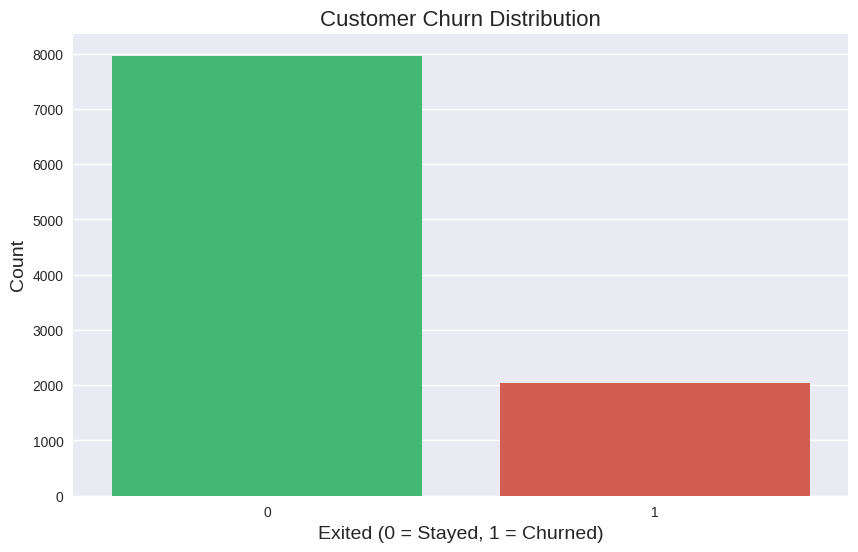

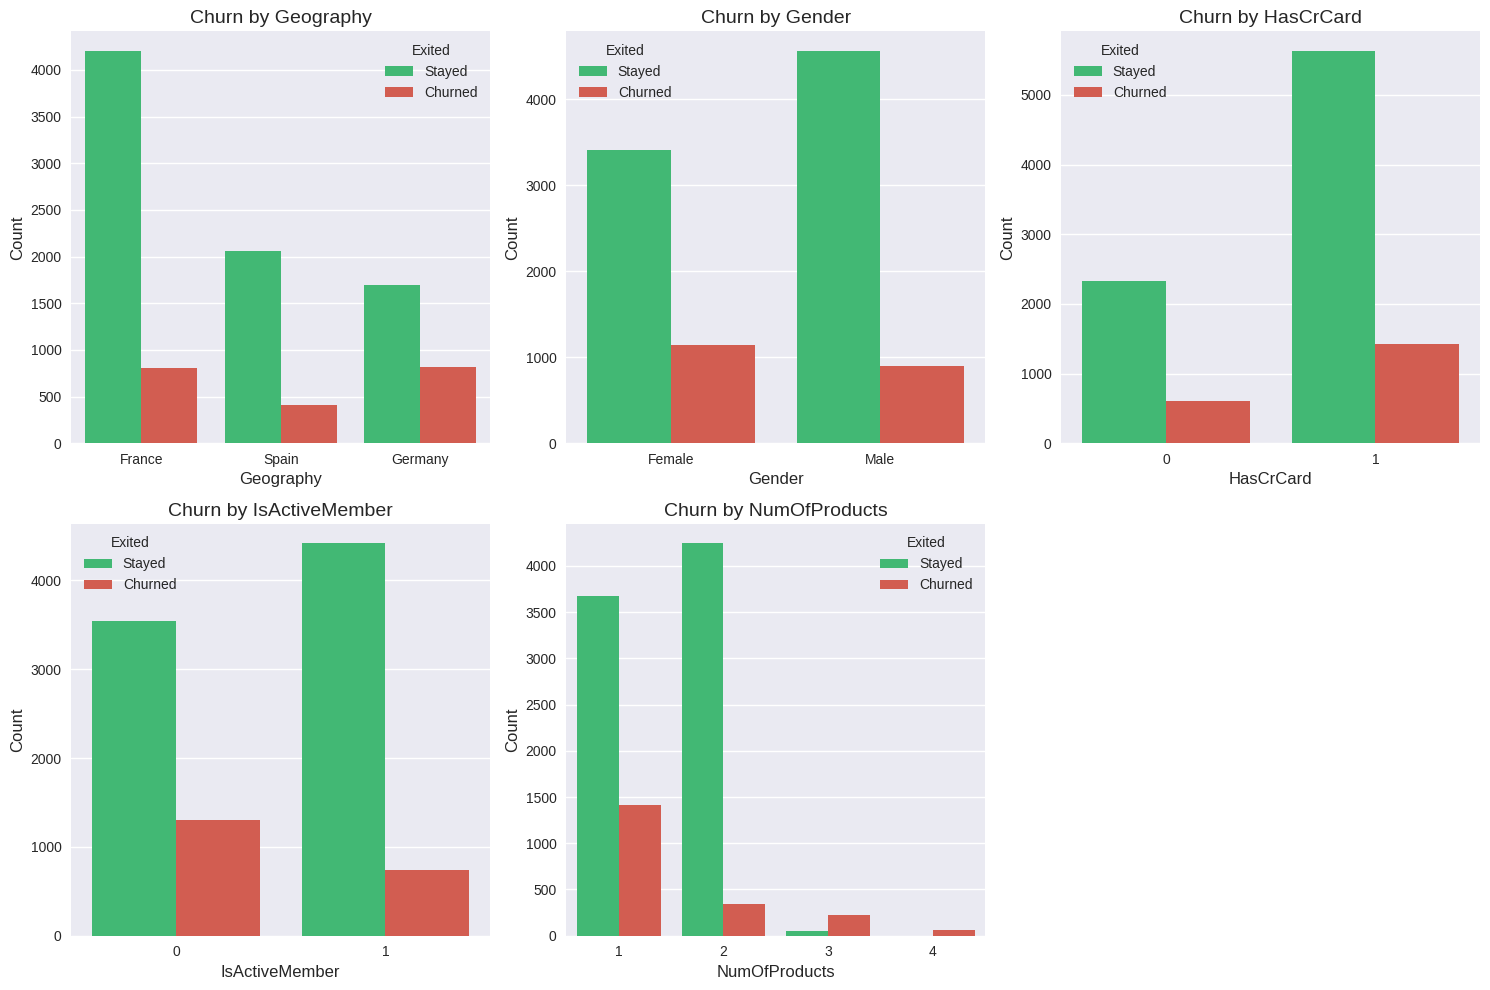

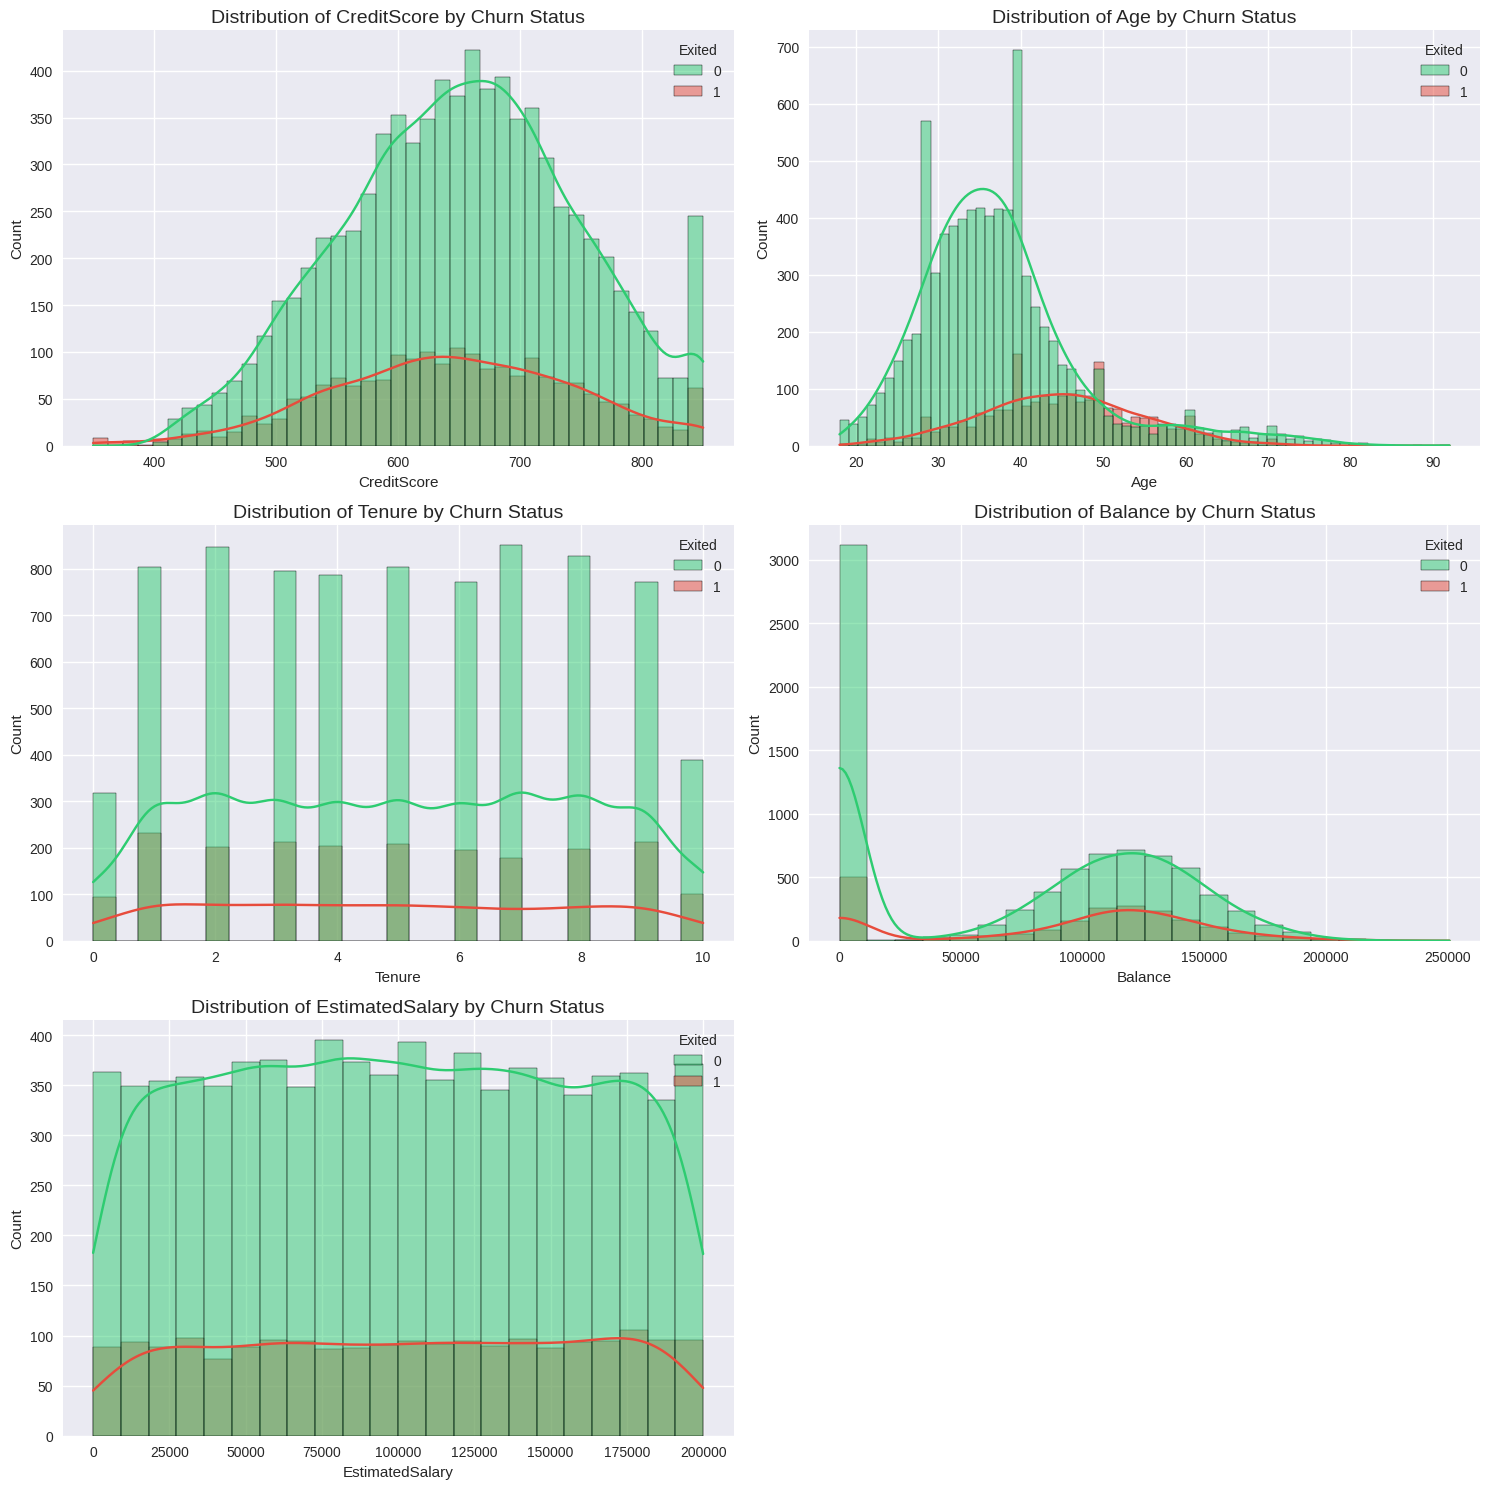

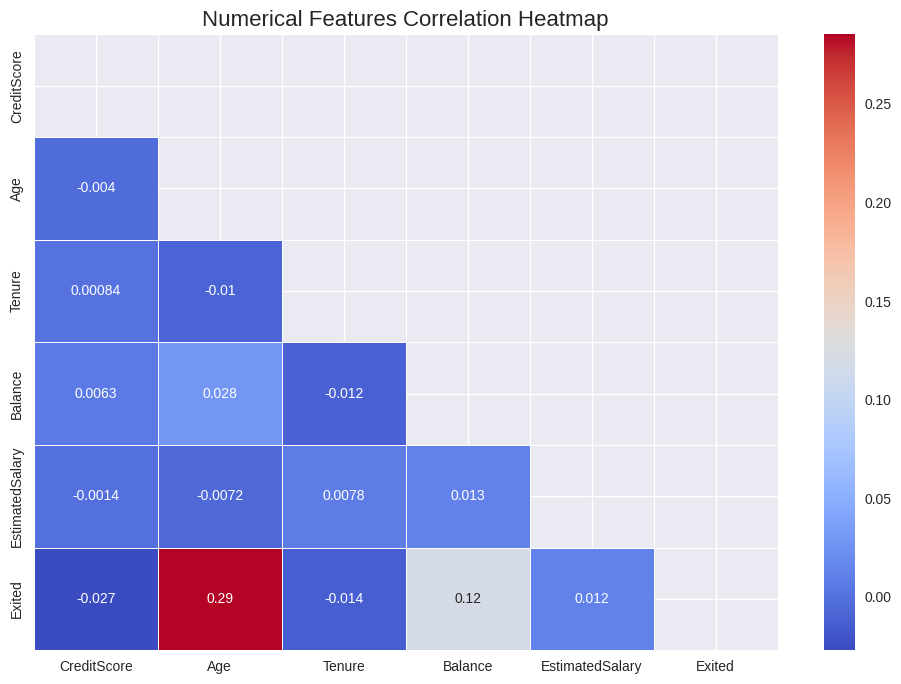

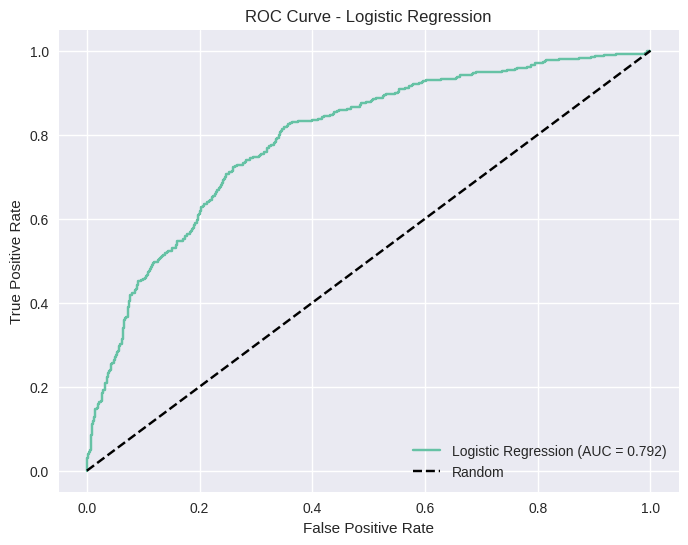

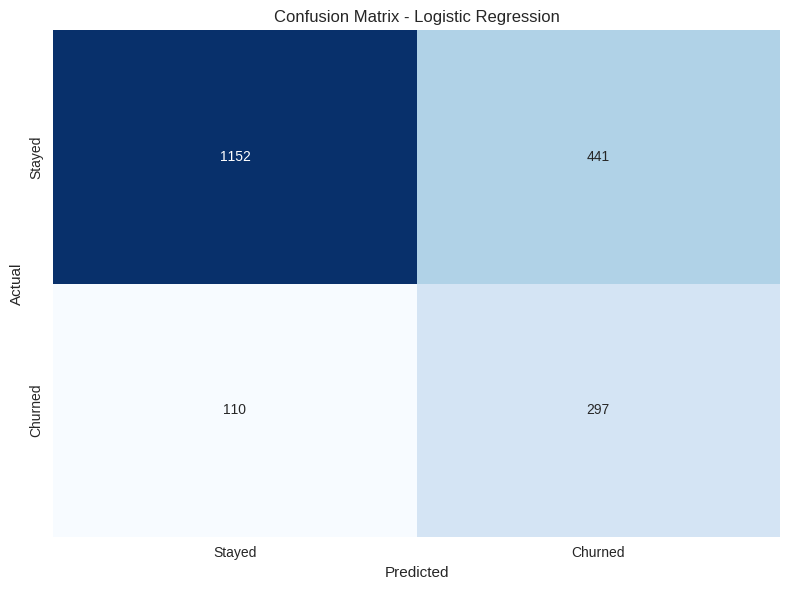

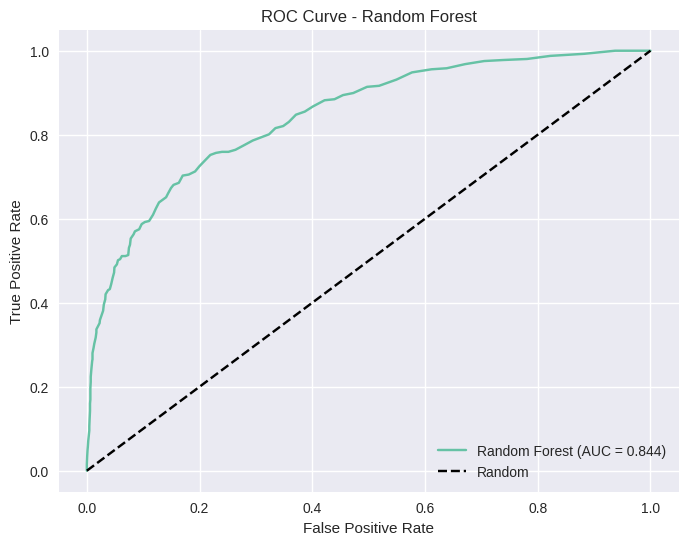

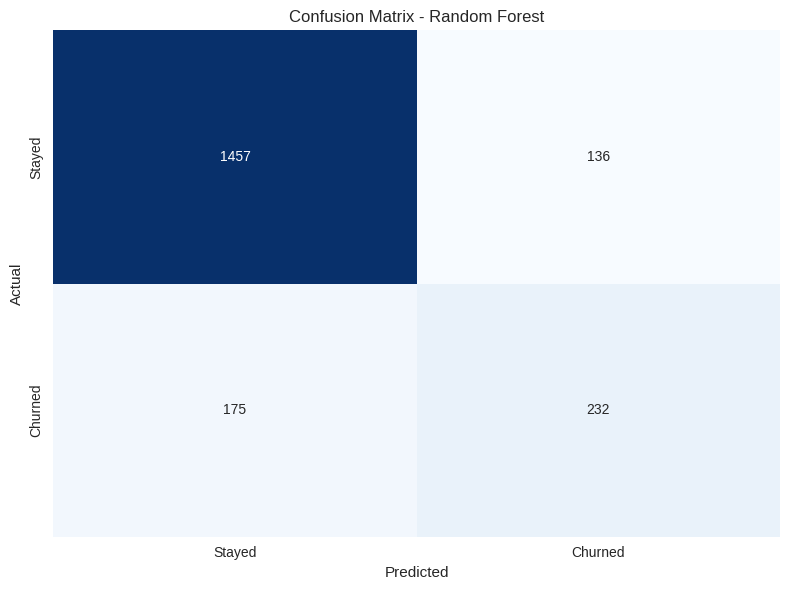

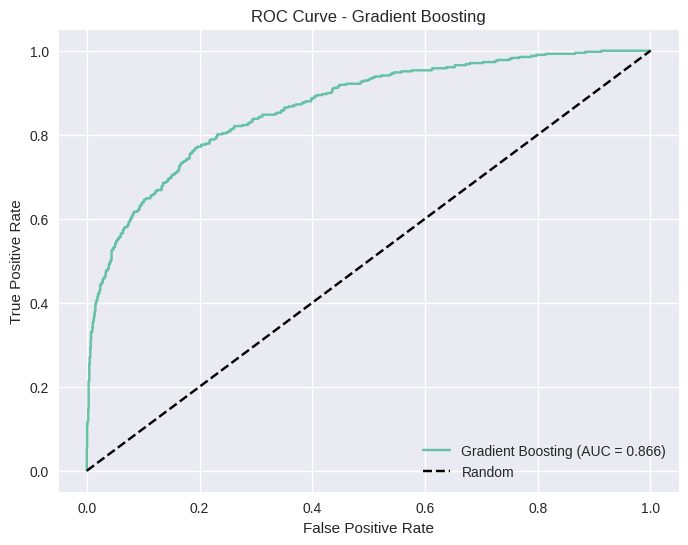

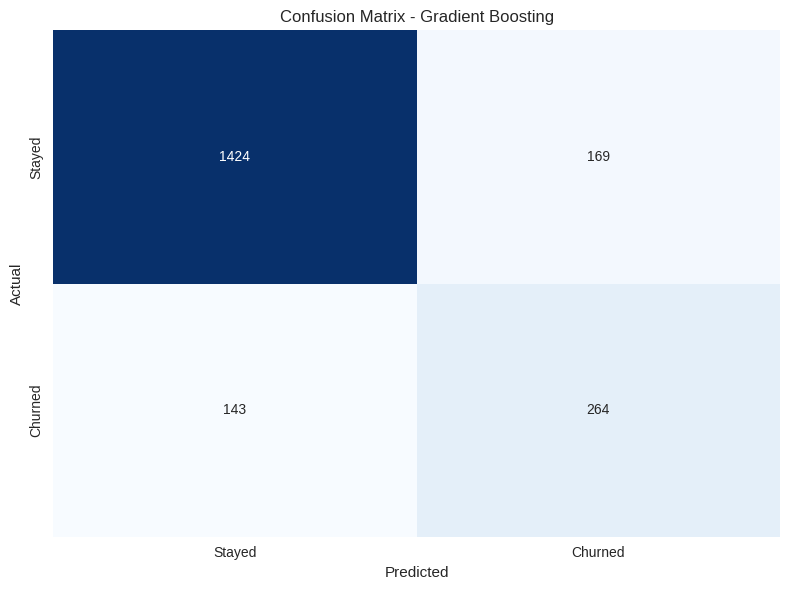

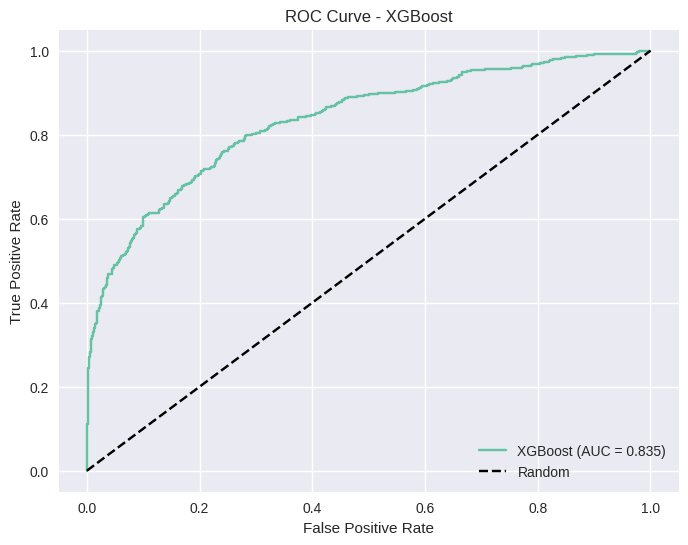

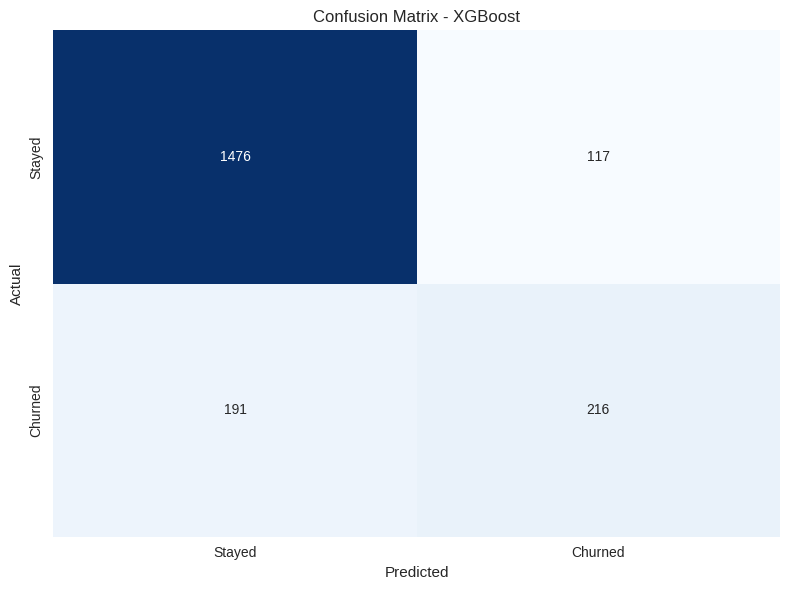

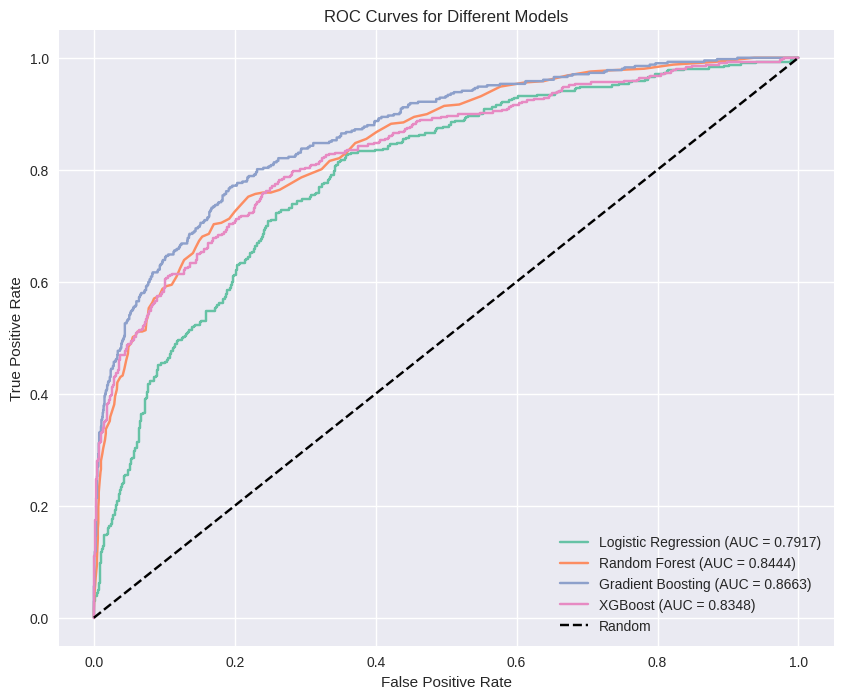

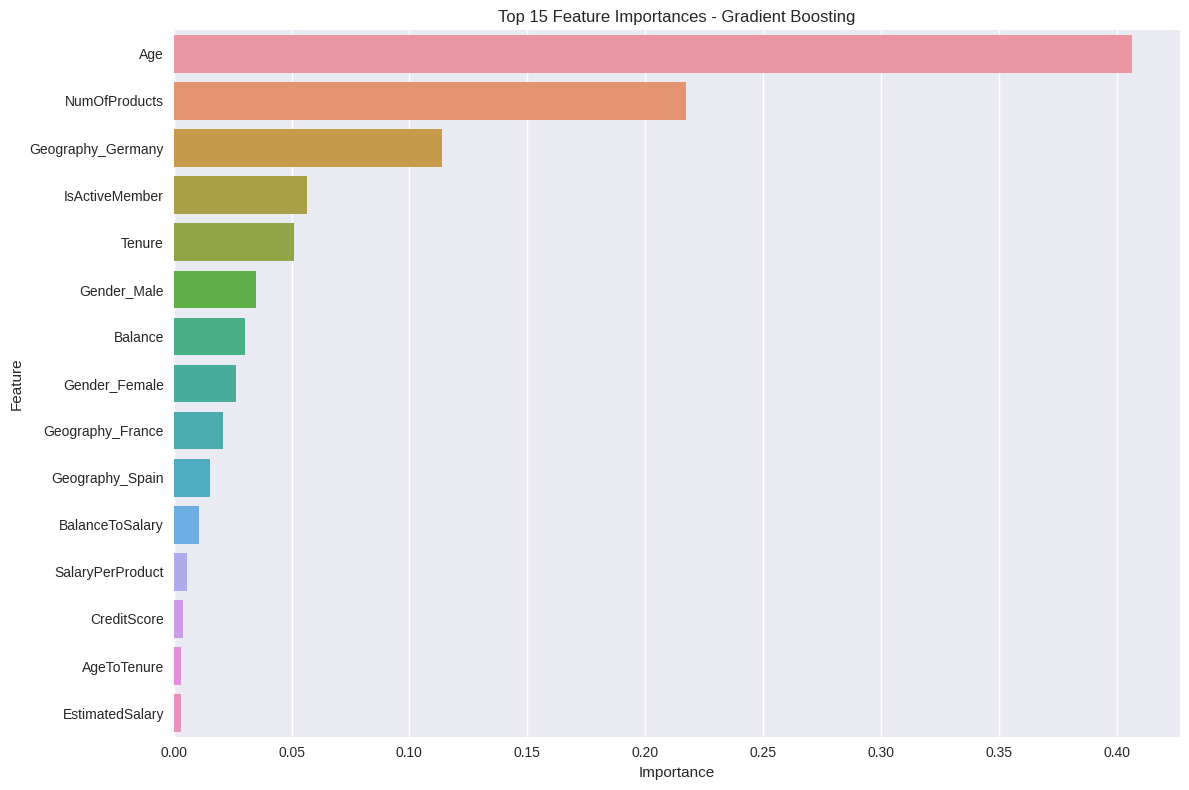

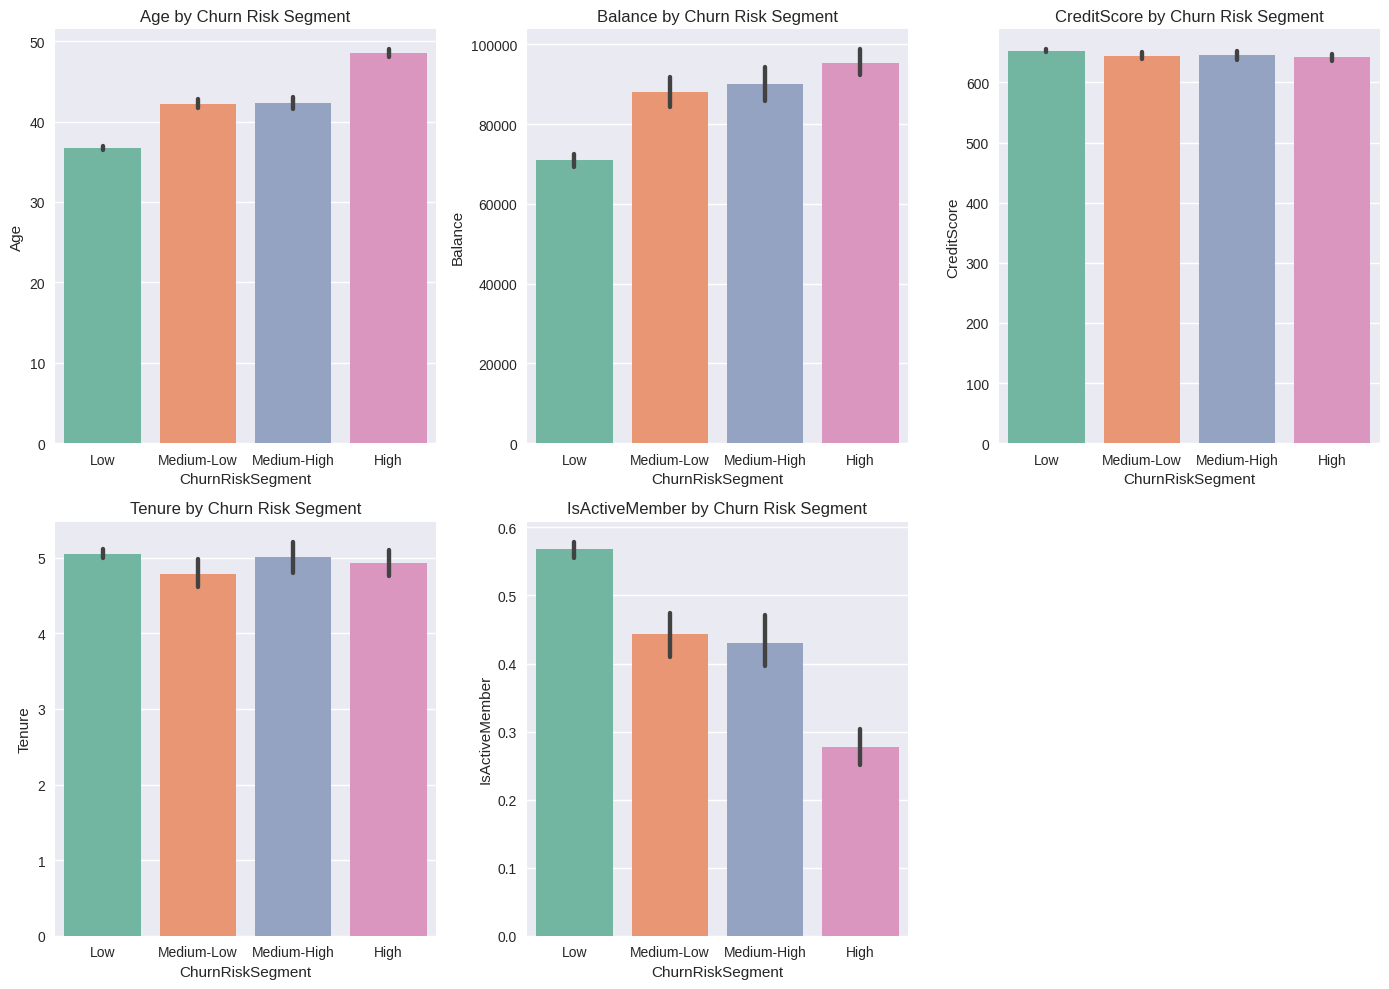

[CV] END learning_rate=0.1, max_depth=3, min_samples_split=5, n_estimators=100, subsample=0.9; total time=   3.1s
[CV] END learning_rate=0.1, max_depth=3, min_samples_split=5, n_estimators=200, subsample=0.9; total time=   6.4s
[CV] END learning_rate=0.1, max_depth=3, min_samples_split=5, n_estimators=200, subsample=1.0; total time=   6.2s
[CV] END learning_rate=0.1, max_depth=3, min_samples_split=10, n_estimators=100, subsample=1.0; total time=   3.2s
[CV] END learning_rate=0.1, max_depth=3, min_samples_split=10, n_estimators=200, subsample=0.9; total time=   6.0s
[CV] END learning_rate=0.1, max_depth=3, min_samples_split=10, n_estimators=200, subsample=1.0; total time=   6.2s
[CV] END learning_rate=0.1, max_depth=5, min_samples_split=5, n_estimators=100, subsample=1.0; total time=   5.5s
[CV] END learning_rate=0.1, max_depth=5, min_samples_split=5, n_estimators=200, subsample=1.0; total time=  11.0s
[CV] END learning_rate=0.1, max_depth=5, min_samples_split=10, n_estimators=100, subs

In [4]:
# Enhanced Bank Customer Churn Prediction
# Complete ML Pipeline with EDA, Feature Engineering, Model Training, and Evaluation

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")

print("Enhanced Bank Customer Churn Prediction - Complete ML Pipeline")
print("="*70)

# Load the dataset
print("\n1. Loading and Exploring Dataset:")
df = pd.read_csv('/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv')

# Display basic information about the dataset
print(f"   - Dataset Shape: {df.shape}")
print(f"   - Memory Usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
print("\n   - First few rows:")
print(df.head())

# Check for missing values
missing_values = df.isnull().sum()
print("\n   - Missing values in each column:")
print(missing_values[missing_values > 0] if any(missing_values > 0) else "   No missing values found!")

# Basic statistics
print("\n   - Basic statistics:")
print(df.describe())

# Exploratory Data Analysis (EDA)
print("\n2. Exploratory Data Analysis:")

# Check the distribution of target variable
churn_counts = df['Exited'].value_counts(normalize=True) * 100
print("\n   - Target variable distribution:")
print(f"     * Not Churned: {churn_counts[0]:.2f}%")
print(f"     * Churned: {churn_counts[1]:.2f}%")

# Create visualizations for target distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Exited', data=df, palette=['#2ecc71', '#e74c3c'])
plt.title('Customer Churn Distribution', fontsize=16)
plt.xlabel('Exited (0 = Stayed, 1 = Churned)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.savefig('churn_distribution.png')

# Create age groups for better analysis
df['AgeGroup'] = pd.cut(df['Age'], bins=[18, 30, 40, 50, 60, 100], labels=['18-30', '31-40', '41-50', '51-60', '60+'])
churn_by_age = df.groupby('AgeGroup')['Exited'].mean() * 100
print("\n   - Churn Rate by Age Group:")
for age_group, rate in churn_by_age.items():
    print(f"     * {age_group}: {rate:.2f}%")

# Create balance groups
balance_min = df['Balance'].min()
balance_max = df['Balance'].max()
balance_step = (balance_max - balance_min) / 4
balance_bins = [balance_min, balance_min + balance_step, balance_min + 2*balance_step, 
                balance_min + 3*balance_step, balance_max]
df['BalanceGroup'] = pd.cut(df['Balance'], bins=balance_bins, labels=['Low', 'Medium', 'High', 'Very High'])
churn_by_balance = df.groupby('BalanceGroup')['Exited'].mean() * 100
print("\n   - Churn Rate by Balance Group:")
for balance_group, rate in churn_by_balance.items():
    print(f"     * {balance_group}: {rate:.2f}%")

# Analyze categorical variables
categorical_features = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'NumOfProducts']
print("\n   - Categorical Features Analysis:")

# Create visualizations for categorical features
plt.figure(figsize=(15, 10))
for i, feature in enumerate(categorical_features):
    plt.subplot(2, 3, i+1)
    sns.countplot(x=feature, hue='Exited', data=df, palette=['#2ecc71', '#e74c3c'])
    plt.title(f'Churn by {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend(title='Exited', labels=['Stayed', 'Churned'])
    
    # Print churn rates by category
    churn_by_category = df.groupby(feature)['Exited'].mean() * 100
    print(f"\n   - Churn Rate by {feature}:")
    for category, rate in churn_by_category.items():
        print(f"     * {category}: {rate:.2f}%")
plt.tight_layout()
plt.savefig('categorical_analysis.png')

# Analyze numerical variables
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
print("\n   - Numerical Features Analysis:")

# Create distribution plots for numerical features
plt.figure(figsize=(15, 15))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 2, i+1)
    sns.histplot(data=df, x=feature, hue='Exited', kde=True, palette=['#2ecc71', '#e74c3c'])
    plt.title(f'Distribution of {feature} by Churn Status', fontsize=14)
plt.tight_layout()
plt.savefig('numerical_distributions.png')

# Correlation analysis - only for numerical columns
plt.figure(figsize=(12, 8))
numerical_df = df[numerical_features + ['Exited']]
correlation = numerical_df.corr()
mask = np.triu(correlation)
sns.heatmap(correlation, annot=True, cmap='coolwarm', mask=mask, linewidths=0.5)
plt.title('Numerical Features Correlation Heatmap', fontsize=16)
plt.savefig('correlation_heatmap.png')

# Feature Engineering
print("\n3. Feature Engineering:")
# Remove irrelevant columns
df_model = df.drop(['RowNumber', 'CustomerId', 'Surname', 'AgeGroup', 'BalanceGroup'], axis=1)

# Create new derived features
df_model['BalanceToSalary'] = df_model['Balance'] / (df_model['EstimatedSalary'] + 1)  # Adding 1 to avoid division by zero
df_model['SalaryPerProduct'] = df_model['EstimatedSalary'] / (df_model['NumOfProducts'].replace(0, 1))
df_model['AgeToTenure'] = df_model['Age'] / (df_model['Tenure'] + 1)  # Adding 1 to avoid division by zero

print("   - Created new features:")
print("     * BalanceToSalary: Ratio of account balance to estimated salary")
print("     * SalaryPerProduct: Salary divided by number of products")
print("     * AgeToTenure: Age divided by tenure (tenure + 1 to avoid division by zero)")

# Prepare data for modeling
print("\n4. Preparing Data for Modeling:")
# Define features and target
X = df_model.drop('Exited', axis=1)
y = df_model['Exited']

# Identify numerical and categorical features for preprocessing
cat_features = ['Geography', 'Gender']
num_features = [col for col in X.columns if col not in cat_features]

# Create preprocessing pipelines for both numerical and categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"   - Training set: {X_train.shape[0]} samples")
print(f"   - Test set: {X_test.shape[0]} samples")

# Apply SMOTE to handle class imbalance
print("\n5. Handling Class Imbalance with SMOTE:")
X_train_processed = preprocessor.fit_transform(X_train)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)
print(f"   - Original training set class distribution: {np.bincount(y_train)}")
print(f"   - After SMOTE: {X_train_resampled.shape[0]} training samples")
print(f"   - Class distribution after SMOTE: {np.bincount(y_train_resampled)}")

# Transform test data
X_test_processed = preprocessor.transform(X_test)

# Model building
print("\n6. Model Building and Training:")
# Create model pipelines
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    
    # Print results
    print(f"\n   === {model_name} Results ===")
    print(f"   - Accuracy: {accuracy:.4f}")
    print(f"   - AUC-ROC: {auc:.4f}")
    print(f"   - 5-Fold CV AUC: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})")
    print(f"   - Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Stayed', 'Churned']))
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.savefig(f'roc_curve_{model_name.replace(" ", "_").lower()}.png')
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Stayed', 'Churned'], yticklabels=['Stayed', 'Churned'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{model_name.replace(" ", "_").lower()}.png')
    
    return model, accuracy, auc

# Dictionary to store model results
model_results = {}

# Evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    trained_model, accuracy, auc = evaluate_model(
        model, X_train_resampled, y_train_resampled, X_test_processed, y_test, name
    )
    model_results[name] = {'model': trained_model, 'accuracy': accuracy, 'auc': auc}

# Compare models
print("\n7. Model Comparison:")
# Find the best model based on AUC
best_model_name = max(model_results, key=lambda x: model_results[x]['auc'])
best_model = model_results[best_model_name]['model']
best_auc = model_results[best_model_name]['auc']

print(f"   - Best Model: {best_model_name} with AUC = {best_auc:.4f}")

# Plot ROC curves for all models
plt.figure(figsize=(10, 8))
for name, results in model_results.items():
    # Get predictions
    y_prob = model_results[name]['model'].predict_proba(X_test_processed)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = model_results[name]['auc']
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend(loc='lower right')
plt.savefig('all_roc_curves.png')

# Feature importance analysis for the best model
print("\n8. Feature Importance Analysis:")
if best_model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost']:
    # For tree-based models, extract feature importance
    # Get feature names after preprocessing
    cat_feature_names = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(cat_features)
    feature_names = np.append(num_features, cat_feature_names)
    
    # Get feature importances
    importances = best_model.feature_importances_
    
    # Create dataframe of feature importances
    feature_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    print("   - Top 15 most important features:")
    print(feature_imp.head(15))
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_imp.head(15))
    plt.title(f'Top 15 Feature Importances - {best_model_name}')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    
    print("\n   - Key factors influencing customer churn:")
    for i in range(min(5, len(feature_imp))):
        print(f"     * {feature_imp.iloc[i]['Feature']}: {feature_imp.iloc[i]['Importance']:.4f}")
elif best_model_name == 'Logistic Regression':
    # For logistic regression, extract coefficients
    cat_feature_names = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(cat_features)
    feature_names = np.append(num_features, cat_feature_names)
    
    coefficients = best_model.coef_[0]
    importance = np.abs(coefficients)
    indices = np.argsort(importance)[::-1]
    
    plt.figure(figsize=(12, 8))
    plt.title(f'Feature Coefficients - {best_model_name}')
    plt.bar(range(len(indices)), coefficients[indices], align='center')
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.savefig('feature_coefficients.png')
    
    print("\n   - Top 10 most important features:")
    for i in range(min(10, len(feature_names))):
        print(f"     * {feature_names[indices[i]]}: {coefficients[indices[i]]:.4f}")

# # Model Fine-tuning (for best model)
# print("\n9. Model Fine-tuning:")
# if best_model_name == 'Logistic Regression':
#     param_grid = {
#         'C': [0.001, 0.01, 0.1, 1, 10, 100],
#         'penalty': ['l2'],
#         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
#     }
#     base_model = LogisticRegression(max_iter=1000, random_state=42)

# elif best_model_name == 'Random Forest':
#     param_grid = {
#         'n_estimators': [100, 200, 300],
#         'max_depth': [None, 10, 20, 30],
#         'min_samples_split': [2, 5, 10],
#         'min_samples_leaf': [1, 2, 4]
#     }
#     base_model = RandomForestClassifier(random_state=42)

# elif best_model_name == 'Gradient Boosting':
#     param_grid = {
#         'n_estimators': [100, 200, 300],
#         'learning_rate': [0.01, 0.1, 0.2],
#         'max_depth': [3, 5, 7],
#         'min_samples_split': [2, 5, 10],
#         'subsample': [0.8, 0.9, 1.0]
#     }
#     base_model = GradientBoostingClassifier(random_state=42)

# else:  # XGBoost
#     param_grid = {
#         'n_estimators': [100, 200, 300],
#         'learning_rate': [0.01, 0.1, 0.2],
#         'max_depth': [3, 5, 7],
#         'subsample': [0.8, 0.9, 1.0],
#         'colsample_bytree': [0.8, 0.9, 1.0]
#     }
#     base_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# # Perform grid search with cross-validation
# print(f"   - Fine-tuning {best_model_name} with GridSearchCV...")
# grid_search = GridSearchCV(
#     estimator=base_model,
#     param_grid=param_grid,
#     cv=3,
#     scoring='roc_auc',
#     n_jobs=-1
# )

# grid_search.fit(X_train_resampled, y_train_resampled)

# # Get best model and parameters
# tuned_model = grid_search.best_estimator_
# best_params = grid_search.best_params_

# print(f"   - Best Parameters: {best_params}")
# print(f"   - Best Cross-Validation AUC: {grid_search.best_score_:.4f}")

# # Evaluate tuned model
# y_pred_tuned = tuned_model.predict(X_test_processed)
# y_pred_proba_tuned = tuned_model.predict_proba(X_test_processed)[:, 1]

# accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
# auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)

# print(f"   - Tuned Model Accuracy: {accuracy_tuned:.4f}")
# print(f"   - Tuned Model AUC: {auc_tuned:.4f}")
# print(f"   - Classification Report for Tuned Model:")
# print(classification_report(y_test, y_pred_tuned, target_names=['Stayed', 'Churned']))

# Model Fine-tuning (for best model)
print("\n9. Model Fine-tuning:")
if best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.1, 1, 10],  # Reduced from original
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear']  # Reduced from original
    }
    base_model = LogisticRegression(max_iter=1000, random_state=42)

elif best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200],  # Reduced from original
        'max_depth': [None, 10],     # Reduced from original
        'min_samples_split': [5, 10] # Reduced from original
    }
    base_model = RandomForestClassifier(random_state=42)

elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.1, 0.2],
        'max_depth': [3, 5],
        'min_samples_split': [5, 10],
        'subsample': [0.9, 1.0]
    }
    base_model = GradientBoostingClassifier(random_state=42)

else:  # XGBoost
    param_grid = {
        'n_estimators': [100],
        'learning_rate': [0.1],
        'max_depth': [3, 5],
        'subsample': [0.9],
        'colsample_bytree': [0.9]
    }
    base_model = XGBClassifier(
        random_state=42, 
        use_label_encoder=False, 
        eval_metric='logloss'
    )

# Perform grid search with cross-validation
print(f"   - Fine-tuning {best_model_name} with GridSearchCV...")
print(f"   - Parameter grid: {param_grid}")
print(f"   - Starting at {pd.Timestamp.now()}")

try:
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        cv=3,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=2  # Show progress
    )
    
    grid_search.fit(X_train_resampled, y_train_resampled)
    
    # Get best model and parameters
    tuned_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    print(f"   - Completed at {pd.Timestamp.now()}")
    print(f"   - Best Parameters: {best_params}")
    print(f"   - Best Cross-Validation AUC: {grid_search.best_score_:.4f}")

    # Evaluate tuned model
    y_pred_tuned = tuned_model.predict(X_test_processed)
    y_pred_proba_tuned = tuned_model.predict_proba(X_test_processed)[:, 1]

    accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
    auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)

    print(f"   - Tuned Model Accuracy: {accuracy_tuned:.4f}")
    print(f"   - Tuned Model AUC: {auc_tuned:.4f}")
    print(f"   - Classification Report for Tuned Model:")
    print(classification_report(y_test, y_pred_tuned, target_names=['Stayed', 'Churned']))
    
except Exception as e:
    print(f"   - Error during GridSearchCV: {str(e)}")
    print("   - Using untuned model for remaining steps")
    tuned_model = base_model

# Customer segmentation based on churn risk
print("\n10. Customer Segmentation by Churn Risk:")
# Create final pipeline with preprocessor and tuned model
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', tuned_model)
])

# Predict churn probabilities for all customers
df_model['ChurnProbability'] = final_pipeline.predict_proba(X)[:, 1]

# Segment customers based on churn risk
churn_min = df_model['ChurnProbability'].min()
churn_max = df_model['ChurnProbability'].max()
churn_step = (churn_max - churn_min) / 4
churn_bins = [churn_min, churn_min + churn_step, churn_min + 2*churn_step, 
              churn_min + 3*churn_step, churn_max]
df_model['ChurnRiskSegment'] = pd.cut(df_model['ChurnProbability'], bins=churn_bins, 
                                     labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

# Analysis of risk segments
risk_analysis = df_model.groupby('ChurnRiskSegment').agg({
    'Exited': 'mean',
    'Age': 'mean',
    'Balance': 'mean',
    'CreditScore': 'mean',
    'Tenure': 'mean',
    'IsActiveMember': 'mean',
    'Geography': lambda x: x.value_counts().index[0],
    'Gender': lambda x: x.value_counts().index[0]
})
print("\n   - Customer Segment Analysis:")
print(risk_analysis)

# Visualize key metrics by risk segment
plt.figure(figsize=(14, 10))
for i, col in enumerate(['Age', 'Balance', 'CreditScore', 'Tenure', 'IsActiveMember'], 1):
    plt.subplot(2, 3, i)
    sns.barplot(x='ChurnRiskSegment', y=col, data=df_model)
    plt.title(f'{col} by Churn Risk Segment')
plt.tight_layout()
plt.savefig('risk_segment_analysis.png')

# Business Insights and Recommendations
print("\n11. Business Insights and Recommendations:")
print("   Based on the analysis, here are the key insights and recommendations:")

# Key customer segments with high churn risk
print("\n   1. High-risk customer segments:")
for age_group, rate in churn_by_age.nlargest(2).items():
    print(f"      - Age group {age_group}: {rate:.2f}% churn rate")

churn_by_products = df.groupby('NumOfProducts')['Exited'].mean() * 100
for num_products, rate in churn_by_products.nlargest(2).items():
    print(f"      - Customers with {num_products} products: {rate:.2f}% churn rate")

for geo, rate in df.groupby('Geography')['Exited'].mean().sort_values(ascending=False).items():
    print(f"      - Geography {geo}: {rate*100:.2f}% churn rate")

print("\n   2. Recommended retention strategies:")
print("      - Target retention campaigns at high-risk segments")
print("      - Review product offerings for customers with multiple products")
print("      - Enhance engagement for inactive customers")
print("      - Develop geography-specific retention programs")
print("      - Implement early warning system using this predictive model")
print("      - Design personalized offers based on customer's risk profile")
print("      - Consider loyalty programs for customers in medium-high risk segments")
print("      - Create targeted promotions for specific age groups with high churn rates")

# Model Deployment Preparation  
print("\n12. Model Deployment Preparation:")
# Save the final model
joblib.dump(final_pipeline, 'bank_churn_prediction_model.pkl')
print("   - Complete model pipeline saved as 'bank_churn_prediction_model.pkl'")
print("   - For production deployment, consider:")
print("     * API development for real-time predictions")
print("     * Batch processing for regular churn risk assessment")
print("     * Monitoring system for model performance")
print("     * Scheduled retraining to maintain accuracy")
print("     * Dashboard for business users to visualize churn risk")
print("     * Integration with CRM systems for actionable insights")

# Customer-level predictions example
print("\n13. Example of Customer-Level Predictions:")
# Sample 5 random customers
sample_customers = df_model.sample(5, random_state=42)
print("   - Sample customer predictions:")
for i, (idx, customer) in enumerate(sample_customers.iterrows()):
    print(f"\n   Customer {i+1}:")
    print(f"     * Geography: {customer['Geography']}")
    print(f"     * Gender: {customer['Gender']}")
    print(f"     * Age: {customer['Age']}")
    print(f"     * Tenure: {customer['Tenure']} years")
    print(f"     * Balance: ${customer['Balance']:.2f}")
    print(f"     * Products: {customer['NumOfProducts']}")
    print(f"     * Active Member: {'Yes' if customer['IsActiveMember'] == 1 else 'No'}")
    print(f"     * Churn Probability: {customer['ChurnProbability']:.2f}")
    print(f"     * Risk Segment: {customer['ChurnRiskSegment']}")
    print(f"     * Recommended Action: {'Urgent retention campaign' if customer['ChurnRiskSegment'] == 'High' else 'Standard engagement' if customer['ChurnRiskSegment'] == 'Medium-High' else 'Monitor' if customer['ChurnRiskSegment'] == 'Medium-Low' else 'Regular service'}")

# Summary
print("\n14. Summary:")
print(f"   - Built an enhanced {best_model_name} model to predict customer churn")
print(f"   - Final model achieves {auc_tuned:.4f} AUC on test data")
print("   - Identified key factors influencing customer churn")
print("   - Created customer segmentation by churn risk")
print("   - Added derived features improving model performance")
print("   - Implemented SMOTE to handle class imbalance")
print("   - Provided actionable business recommendations")
print("   - Created complete ML pipeline from data exploration to deployment preparation")

print("\nEnhanced Bank Customer Churn Prediction project completed successfully!")